# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

# Loading the data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train/255.0
x_test = x_test/255.0

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
N, H, W = x_train.shape
D = H * W

# Flattening the data
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [6]:
# Dimensionality of latent space
latent_dim = 100

# Creating Models




In [7]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim, ))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [8]:
def build_discriminator(img_size):
  i = Input(shape=(img_size, ))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [9]:
# Creation and compilation

discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy', 
    optimizer = Adam(0.0002, 0.5),
    metrics=['accuracy']
)

generator = build_generator(latent_dim)

# Create some random noise input of the combined model
z = Input(shape=(latent_dim,))
# This is passed through generator to get image
img = generator(z)

discriminator.trainable=False
fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)

'''
  So, combined model looks like :
    z   -->   img   -->   fake_pred    
'''
combined_model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(0.0002, 0.5)
)

In [10]:
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 333,057
Trainable params: 0
Non-trainable params: 333,057
_________________________________________________________________


In [11]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              103424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               803600    
Total params: 911,120
Trainable params: 909,072
Non-trainable params: 2,048
_________________________________________________________________


In [12]:
combined_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 784)               911120    
_________________________________________________________________
model (Functional)           (None, 1)                 333057    
Total params: 1,244,177
Trainable params: 909,072
Non-trainable params: 335,105
_________________________________________________________________


# Train the GAN

In [13]:
batch_size = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [14]:
def sample_images(epoch) :
  rows, cols = 5, 5
  noise = np.random.randn(rows*cols, latent_dim)
  imgs = generator.predict(noise)

  fig, axis = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axis[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axis[i, j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [15]:
# TRAIN !!!
for epoch in range(epochs):

  ###  DISCRIMINATOR
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

  d_loss = 0.5*(d_loss_real + d_loss_fake)
  d_acc = 0.5*(d_acc_real + d_acc_fake)


  ###  GENERATOR
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch%100==0:
    print(f"epoch {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0 :
    sample_images(epoch)

epoch 1/30000, d_loss: 0.66, d_acc: 0.56, g_loss: 0.54
epoch 101/30000, d_loss: 0.06, d_acc: 1.00, g_loss: 3.69
epoch 201/30000, d_loss: 0.35, d_acc: 0.86, g_loss: 3.10
epoch 301/30000, d_loss: 0.45, d_acc: 0.81, g_loss: 2.42
epoch 401/30000, d_loss: 0.56, d_acc: 0.69, g_loss: 1.86
epoch 501/30000, d_loss: 0.41, d_acc: 0.88, g_loss: 2.35
epoch 601/30000, d_loss: 0.30, d_acc: 0.92, g_loss: 3.20
epoch 701/30000, d_loss: 0.27, d_acc: 0.94, g_loss: 3.33
epoch 801/30000, d_loss: 0.15, d_acc: 1.00, g_loss: 3.78
epoch 901/30000, d_loss: 0.09, d_acc: 1.00, g_loss: 4.53
epoch 1001/30000, d_loss: 0.10, d_acc: 0.98, g_loss: 4.85
epoch 1101/30000, d_loss: 0.06, d_acc: 1.00, g_loss: 5.53
epoch 1201/30000, d_loss: 0.06, d_acc: 1.00, g_loss: 4.21
epoch 1301/30000, d_loss: 0.07, d_acc: 1.00, g_loss: 3.72
epoch 1401/30000, d_loss: 0.19, d_acc: 0.94, g_loss: 4.62
epoch 1501/30000, d_loss: 0.18, d_acc: 0.92, g_loss: 4.59
epoch 1601/30000, d_loss: 0.18, d_acc: 0.95, g_loss: 4.91
epoch 1701/30000, d_loss: 

# Plots

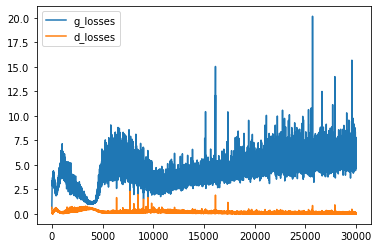

In [16]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [17]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

In [18]:
from skimage.io import imread
def show_snap(ind):
  a = imread(f"gan_images/{ind}.png")
  plt.imshow(a)

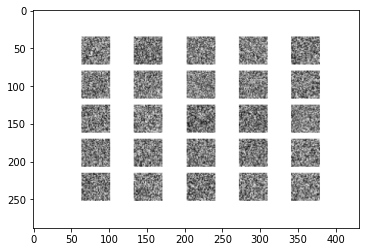

In [19]:
show_snap(0)

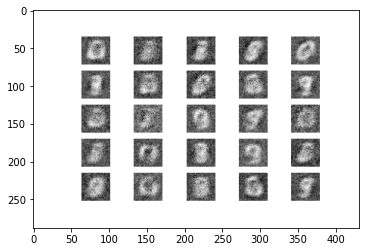

In [23]:
show_snap(10000)

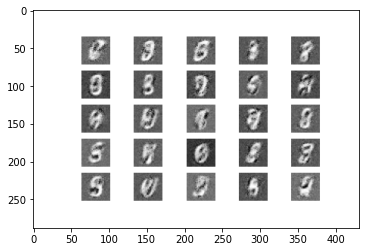

In [24]:
show_snap(20000)

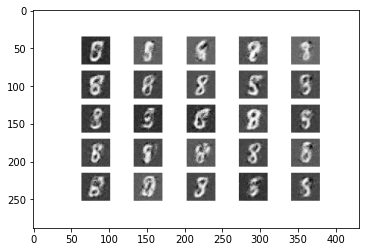

In [27]:
show_snap(25000)

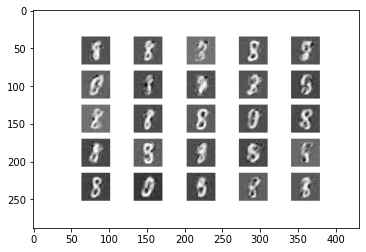

In [28]:
show_snap(29000)

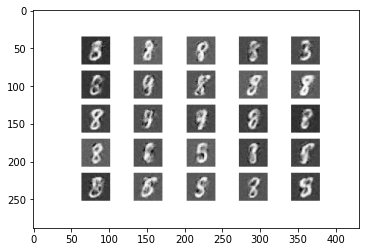

In [29]:
show_snap(29800)

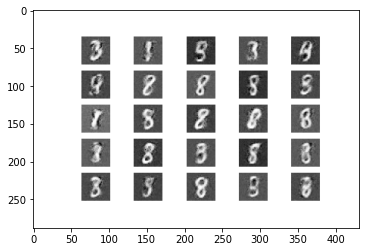

In [34]:
sample_images(30000)
show_snap(30000)